In [2]:
import pandas as pd
import sqlite3
from pathlib import Path

In [3]:
DATA_PATH = Path("../data/raw/bike_buyers_clean.csv")
DB_PATH = Path("../data/bike_buyers.db")

DATA_PATH, DB_PATH

(WindowsPath('../data/raw/bike_buyers_clean.csv'),
 WindowsPath('../data/bike_buyers.db'))

In [4]:
df = pd.read_csv(DATA_PATH)

df.head(), df.shape

(      ID Marital Status  Gender  Income  Children        Education  \
 0  12496        Married  Female   40000         1        Bachelors   
 1  24107        Married    Male   30000         3  Partial College   
 2  14177        Married    Male   80000         5  Partial College   
 3  24381         Single    Male   70000         0        Bachelors   
 4  25597         Single    Male   30000         0        Bachelors   
 
        Occupation Home Owner  Cars Commute Distance   Region  Age  \
 0  Skilled Manual        Yes     0        0-1 Miles   Europe   42   
 1        Clerical        Yes     1        0-1 Miles   Europe   43   
 2    Professional         No     2        2-5 Miles   Europe   60   
 3    Professional        Yes     1       5-10 Miles  Pacific   41   
 4        Clerical         No     0        0-1 Miles   Europe   36   
 
   Purchased Bike  
 0             No  
 1             No  
 2             No  
 3            Yes  
 4            Yes  ,
 (1000, 13))

In [5]:
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

print("Connected to SQLite database")

Connected to SQLite database


In [6]:
cursor.executescript("""
DROP TABLE IF EXISTS purchases;
DROP TABLE IF EXISTS customers;
DROP TABLE IF EXISTS education;
DROP TABLE IF EXISTS occupation;
DROP TABLE IF EXISTS housing;
DROP TABLE IF EXISTS commute;
DROP TABLE IF EXISTS region;

CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    gender TEXT,
    age INTEGER,
    marital_status TEXT,
    children INTEGER,
    income INTEGER
);

CREATE TABLE education (
    education_id INTEGER PRIMARY KEY AUTOINCREMENT,
    education_level TEXT UNIQUE
);

CREATE TABLE occupation (
    occupation_id INTEGER PRIMARY KEY AUTOINCREMENT,
    occupation_name TEXT UNIQUE
);

CREATE TABLE housing (
    housing_id INTEGER PRIMARY KEY AUTOINCREMENT,
    home_owner TEXT,
    cars INTEGER
);

CREATE TABLE commute (
    commute_id INTEGER PRIMARY KEY AUTOINCREMENT,
    commute_distance TEXT UNIQUE
);

CREATE TABLE region (
    region_id INTEGER PRIMARY KEY AUTOINCREMENT,
    region_name TEXT UNIQUE
);

CREATE TABLE purchases (
    purchase_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER,
    education_id INTEGER,
    occupation_id INTEGER,
    housing_id INTEGER,
    commute_id INTEGER,
    region_id INTEGER,
    purchased_bike INTEGER,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
    FOREIGN KEY (education_id) REFERENCES education(education_id),
    FOREIGN KEY (occupation_id) REFERENCES occupation(occupation_id),
    FOREIGN KEY (housing_id) REFERENCES housing(housing_id),
    FOREIGN KEY (commute_id) REFERENCES commute(commute_id),
    FOREIGN KEY (region_id) REFERENCES region(region_id)
);
""")

conn.commit()
print("Tables created successfully")

Tables created successfully


In [7]:
# Insert unique education levels
df[['Education']].drop_duplicates().rename(
    columns={'Education': 'education_level'}
).to_sql('education', conn, if_exists='append', index=False)

# Insert unique occupations
df[['Occupation']].drop_duplicates().rename(
    columns={'Occupation': 'occupation_name'}
).to_sql('occupation', conn, if_exists='append', index=False)

# Insert unique regions
df[['Region']].drop_duplicates().rename(
    columns={'Region': 'region_name'}
).to_sql('region', conn, if_exists='append', index=False)

# Insert unique commute distances
df[['Commute Distance']].drop_duplicates().rename(
    columns={'Commute Distance': 'commute_distance'}
).to_sql('commute', conn, if_exists='append', index=False)

print("Lookup tables inserted successfully")

Lookup tables inserted successfully


In [8]:
customers_df = df[[
    'ID',
    'Gender',
    'Age',
    'Marital Status',
    'Children',
    'Income'
]].rename(columns={
    'ID': 'customer_id',
    'Gender': 'gender',
    'Age': 'age',
    'Marital Status': 'marital_status',
    'Children': 'children',
    'Income': 'income'
})

customers_df.to_sql('customers', conn, if_exists='append', index=False)

print("Customers inserted successfully")

Customers inserted successfully


In [9]:
education_map = pd.read_sql("SELECT * FROM education", conn)
occupation_map = pd.read_sql("SELECT * FROM occupation", conn)
region_map = pd.read_sql("SELECT * FROM region", conn)
commute_map = pd.read_sql("SELECT * FROM commute", conn)

education_map.head(), occupation_map.head()

(   education_id      education_level
 0             1            Bachelors
 1             2      Partial College
 2             3          High School
 3             4  Partial High School
 4             5      Graduate Degree,
    occupation_id occupation_name
 0              1  Skilled Manual
 1              2        Clerical
 2              3    Professional
 3              4          Manual
 4              5      Management)

In [10]:
purchases_df = df[['ID', 'Education', 'Occupation', 'Region', 'Commute Distance', 'Purchased Bike']]

purchases_df = purchases_df.merge(
    education_map, left_on='Education', right_on='education_level'
).merge(
    occupation_map, left_on='Occupation', right_on='occupation_name'
).merge(
    region_map, left_on='Region', right_on='region_name'
).merge(
    commute_map, left_on='Commute Distance', right_on='commute_distance'
)

purchases_df['purchased_bike'] = purchases_df['Purchased Bike'].map({'Yes': 1, 'No': 0})

final_purchases = purchases_df[[
    'ID',
    'education_id',
    'occupation_id',
    'commute_id',
    'region_id',
    'purchased_bike'
]].rename(columns={'ID': 'customer_id'})

final_purchases.head()

,customer_id,education_id,occupation_id,commute_id,region_id,purchased_bike
0,12496,1,1,1,1,0
1,24107,2,2,1,1,0
2,14177,2,3,2,1,0
3,24381,1,3,3,2,1
4,25597,1,2,1,1,1


In [11]:
final_purchases.to_sql('purchases', conn, if_exists='append', index=False)

print("Purchases inserted successfully")

Purchases inserted successfully


In [12]:
query = """
SELECT
    c.customer_id,
    c.gender,
    c.age,
    c.marital_status,
    c.children,
    c.income,
    e.education_level,
    o.occupation_name,
    r.region_name,
    cm.commute_distance,
    h.home_owner,
    h.cars,
    p.purchased_bike
FROM purchases p
JOIN customers c ON p.customer_id = c.customer_id
JOIN education e ON p.education_id = e.education_id
JOIN occupation o ON p.occupation_id = o.occupation_id
JOIN region r ON p.region_id = r.region_id
JOIN commute cm ON p.commute_id = cm.commute_id
LEFT JOIN housing h ON 1=1
"""
df_model = pd.read_sql(query, conn)

df_model.head(), df_model.shape

(   customer_id  gender  age marital_status  children  income  education_level  \
 0        12496  Female   42        Married         1   40000        Bachelors   
 1        24107    Male   43        Married         3   30000  Partial College   
 2        14177    Male   60        Married         5   80000  Partial College   
 3        24381    Male   41         Single         0   70000        Bachelors   
 4        25597    Male   36         Single         0   30000        Bachelors   
 
   occupation_name region_name commute_distance home_owner  cars  \
 0  Skilled Manual      Europe        0-1 Miles       None  None   
 1        Clerical      Europe        0-1 Miles       None  None   
 2    Professional      Europe        2-5 Miles       None  None   
 3    Professional     Pacific       5-10 Miles       None  None   
 4        Clerical      Europe        0-1 Miles       None  None   
 
    purchased_bike  
 0               0  
 1               0  
 2               0  
 3          

In [13]:
housing_df = df[['Home Owner', 'Cars']].drop_duplicates().rename(columns={
    'Home Owner': 'home_owner',
    'Cars': 'cars'
})

housing_df.to_sql('housing', conn, if_exists='append', index=False)

print("Housing table populated")

Housing table populated


In [14]:
housing_map = pd.read_sql("SELECT * FROM housing", conn)
housing_map.head()

,housing_id,home_owner,cars
0,1,Yes,0
1,2,Yes,1
2,3,No,2
3,4,No,0
4,5,Yes,4


In [15]:
# Rebuild purchases with housing_id
purchases_fixed = df[['ID', 'Education', 'Occupation', 'Region', 'Commute Distance', 'Home Owner', 'Cars', 'Purchased Bike']]

purchases_fixed = purchases_fixed.merge(
    education_map, left_on='Education', right_on='education_level'
).merge(
    occupation_map, left_on='Occupation', right_on='occupation_name'
).merge(
    region_map, left_on='Region', right_on='region_name'
).merge(
    commute_map, left_on='Commute Distance', right_on='commute_distance'
).merge(
    housing_map, left_on=['Home Owner', 'Cars'], right_on=['home_owner', 'cars']
)

purchases_fixed['purchased_bike'] = purchases_fixed['Purchased Bike'].map({'Yes': 1, 'No': 0})

final_purchases_fixed = purchases_fixed[[
    'ID',
    'education_id',
    'occupation_id',
    'housing_id',
    'commute_id',
    'region_id',
    'purchased_bike'
]].rename(columns={'ID': 'customer_id'})

In [16]:
cursor.execute("DELETE FROM purchases")
conn.commit()

final_purchases_fixed.to_sql('purchases', conn, if_exists='append', index=False)

print("Purchases table fixed with housing_id")

Purchases table fixed with housing_id


In [17]:
query = """
SELECT
    c.customer_id,
    c.gender,
    c.age,
    c.marital_status,
    c.children,
    c.income,
    e.education_level,
    o.occupation_name,
    r.region_name,
    cm.commute_distance,
    h.home_owner,
    h.cars,
    p.purchased_bike
FROM purchases p
JOIN customers c ON p.customer_id = c.customer_id
JOIN education e ON p.education_id = e.education_id
JOIN occupation o ON p.occupation_id = o.occupation_id
JOIN region r ON p.region_id = r.region_id
JOIN commute cm ON p.commute_id = cm.commute_id
JOIN housing h ON p.housing_id = h.housing_id
"""

df_model = pd.read_sql(query, conn)
df_model.head(), df_model.isna().sum()

(   customer_id  gender  age marital_status  children  income  education_level  \
 0        12496  Female   42        Married         1   40000        Bachelors   
 1        24107    Male   43        Married         3   30000  Partial College   
 2        14177    Male   60        Married         5   80000  Partial College   
 3        24381    Male   41         Single         0   70000        Bachelors   
 4        25597    Male   36         Single         0   30000        Bachelors   
 
   occupation_name region_name commute_distance home_owner  cars  \
 0  Skilled Manual      Europe        0-1 Miles        Yes     0   
 1        Clerical      Europe        0-1 Miles        Yes     1   
 2    Professional      Europe        2-5 Miles         No     2   
 3    Professional     Pacific       5-10 Miles        Yes     1   
 4        Clerical      Europe        0-1 Miles         No     0   
 
    purchased_bike  
 0               0  
 1               0  
 2               0  
 3          

In [18]:
df_model['purchased_bike'].value_counts(normalize=True)

purchased_bike
0    0.519
1    0.481
Name: proportion, dtype: float64

In [19]:
df_model.describe(include='all')

,customer_id,gender,age,marital_status,children,income,education_level,occupation_name,region_name,commute_distance,home_owner,cars,purchased_bike
count,1000.000000,1000,1000.000000,1000,1000.000000,1000.000000,1000,1000,1000,1000,1000,1000.000000,1000.000000
unique,NaN,2,NaN,2,NaN,NaN,5,5,3,5,2,NaN,NaN
top,NaN,Male,NaN,Married,NaN,NaN,Bachelors,Professional,North America,0-1 Miles,Yes,NaN,NaN
freq,NaN,509,NaN,539,NaN,NaN,306,276,508,366,685,NaN,NaN
mean,19965.992000,NaN,44.190000,NaN,1.908000,56140.000000,NaN,NaN,NaN,NaN,NaN,1.452000,0.481000
std,5347.333948,NaN,11.353537,NaN,1.626094,31081.609779,NaN,NaN,NaN,NaN,NaN,1.124705,0.499889
min,11000.000000,NaN,25.000000,NaN,0.000000,10000.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,15290.750000,NaN,35.000000,NaN,0.000000,30000.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
50%,19744.000000,NaN,43.000000,NaN,2.000000,60000.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
75%,24470.750000,NaN,52.000000,NaN,3.000000,70000.000000,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000


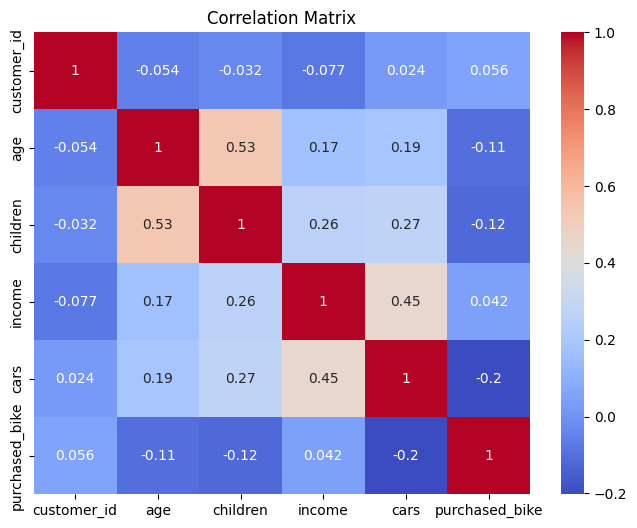

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df_model.select_dtypes(include='number')

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Automated Profiling

In [23]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_model, title="Bike Buyers Profiling Report")
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]
